<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/mnist_train.csv')

In [ ]:
data = np.array(df)
m,n = data.shape
np.random.shuffle(data)

data_train=data.T
Y_train=data_train[0]         #labels
X_train=data_train[1:n]       #Values
X_train = X_train / 255.
_,m_train = X_train.shape

In [ ]:
def ReLU(Z):
    return np.maximum(0,Z);

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

In [ ]:
def init_params():
    w = [np.random.rand(10, 784) * np.sqrt(2/784),np.random.rand(10, 10) * np.sqrt(2/10)]
    b = [np.zeros((10, 1)),np.zeros((10, 1))]
    return w, b

def initialize_adam(w, b):
    L = len(w)
    mw = [np.zeros_like(wl) for wl in w]
    vw = [np.zeros_like(wl) for wl in w]
    mb = [np.zeros_like(bl) for bl in b]
    vb = [np.zeros_like(bl) for bl in b]
    return mw, vw, mb, vb

In [ ]:
def forward_prop(w, b, X):
    a = [X]
    z = []

    for i in range(len(w)):
        zi = w[i].dot(a[i]) + b[i]
        z.append(zi)

        if i == len(w) - 1:
            ai = softmax(zi)
        else:
            ai = ReLU(zi)

        a.append(ai)

    return z, a

In [ ]:
def back_prop(a, z, w , Y, X):
    m = Y.shape[0]
    L = len(w)

    one_hot_Y = np.zeros((Y.size,10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T

    dW = [0] * L
    db = [0] * L
    dZ = [0] * L

    dZ[L-1] = a[L] - one_hot_Y
    dW[L-1] = (1/m) * dZ[L-1].dot(a[L-1].T)
    db[L-1] = (1/m) * np.sum(dZ[L-1], axis=1, keepdims=True)

    for l in reversed(range(L-1)):
        dZ[l] = w[l+1].T.dot(dZ[l+1]) * (z[l] > 0)
        dW[l] = (1/m) * dZ[l].dot(a[l].T)
        db[l] = (1/m) * np.sum(dZ[l], axis=1, keepdims=True)

    return dW, db

def compute_loss(a2, Y):
    one_hot_Y = np.zeros((Y.size,10))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    loss = -np.sum(one_hot_Y * np.log(a2 + 1e-8)) / Y.size
    return loss

def update_params(w, b, dw, db, alpha):
    for i in range(len(w)):
        w[i] -= alpha * dw[i]
        b[i] -= alpha * db[i]
    return w, b

def update_params_adam(w, b, dw, db, mw, vw, mb, vb, t, alpha, beta1=0.9, beta2=0.999, epsilon=1e-8):
    for i in range(len(w)):
        # Atualiza momento
        mw[i] = beta1 * mw[i] + (1 - beta1) * dw[i]
        vw[i] = beta2 * vw[i] + (1 - beta2) * (dw[i]**2)

        mb[i] = beta1 * mb[i] + (1 - beta1) * db[i]
        vb[i] = beta2 * vb[i] + (1 - beta2) * (db[i]**2)

        # Correção de viés
        mw_corr = mw[i] / (1 - beta1**t)
        vw_corr = vw[i] / (1 - beta2**t)

        mb_corr = mb[i] / (1 - beta1**t)
        vb_corr = vb[i] / (1 - beta2**t)

        # Atualiza os pesos
        w[i] -= alpha * mw_corr / (np.sqrt(vw_corr) + epsilon)
        b[i] -= alpha * mb_corr / (np.sqrt(vb_corr) + epsilon)

    return w, b, mw, vw, mb, vb

In [ ]:
def gradient_descent(X, Y, iterations, alpha):
    w, b = init_params()
    m = X.shape[1]
    for i in range(iterations):
        z, a = forward_prop(w, b, X)
        dw, db = back_prop(a, z, w, Y, X)
        w, b = update_params(w, b, dw, db, alpha)
        if i % 10 == 0:
                loss = compute_loss(a[-1], Y)
                acc = get_accuracy(get_predictions(a[-1]), Y)
                print(f"Iteration {i} => Loss: {loss:.4f}, Accuracy: {acc:.4f}")
    return w, b


In [ ]:
def gradient_descent_batches(X, Y, iterations, alpha, batch_size):
    w, b = init_params()
    mw, vw, mb, vb = initialize_adam(w, b)
    m = X.shape[1]  # número total de exemplos
    t = 1

    for i in range(iterations):
        # Embaralhar os dados
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[permutation]

        # Processar em mini-batches
        for j in range(0, m, batch_size):
            end = j + batch_size
            X_batch = X_shuffled[:, j:end]
            Y_batch = Y_shuffled[j:end]

            # Forward + Backward + Update para o mini-batch
            z, a = forward_prop(w, b, X_batch)
            dw, db = back_prop(a, z, w, Y_batch, X_batch)
            w, b, mw, vw, mb, vb = update_params_adam(w, b, dw, db, mw, vw, mb, vb, t, alpha)
            t += 1

        # Monitoramento após cada época
        if i % 10 == 0:
            _, a_all = forward_prop(w, b, X)
            loss = compute_loss(a_all[-1], Y)
            acc = get_accuracy(get_predictions(a_all[-1]), Y)
            print(f"Iteration {i} => Loss: {loss:.4f}, Accuracy: {acc:.4f}")

    return w, b

In [ ]:
# Testing and evaluation
def test_prediction(index, w, b):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], w, b)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

# Calculate accuracy
def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size           #Total de vezes que o valor foi igual ao label / pelo total de valores

def get_predictions(a2):
    return np.argmax(a2,0)

In [ ]:
def make_predictions(X, w, b):
    _, A = forward_prop(w, b, X)
    predictions = np.argmax(A[-1], 0)
    return predictions

In [ ]:
w, b =gradient_descent_batches(X_train, Y_train, 100, 0.001,64)

Iteration 0 => Loss: 0.3496, Accuracy: 0.9036
Iteration 10 => Loss: 0.2206, Accuracy: 0.9370
Iteration 20 => Loss: 0.1939, Accuracy: 0.9442
Iteration 30 => Loss: 0.1754, Accuracy: 0.9499
Iteration 40 => Loss: 0.1697, Accuracy: 0.9512
Iteration 50 => Loss: 0.1608, Accuracy: 0.9535
Iteration 60 => Loss: 0.1516, Accuracy: 0.9558
Iteration 70 => Loss: 0.1489, Accuracy: 0.9564
Iteration 80 => Loss: 0.1445, Accuracy: 0.9582
Iteration 90 => Loss: 0.1406, Accuracy: 0.9591


Prediction:  [4]
Label:  4


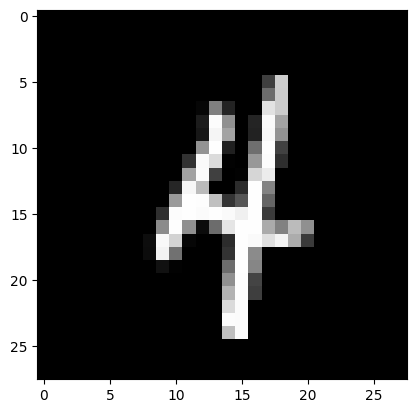

Prediction:  [3]
Label:  2


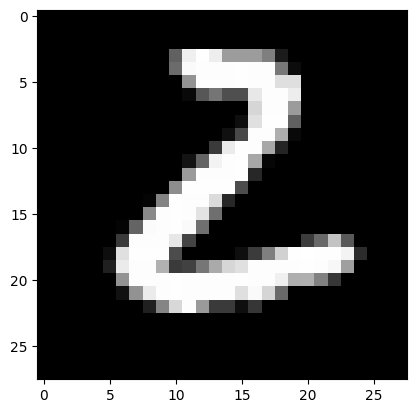

Prediction:  [7]
Label:  7


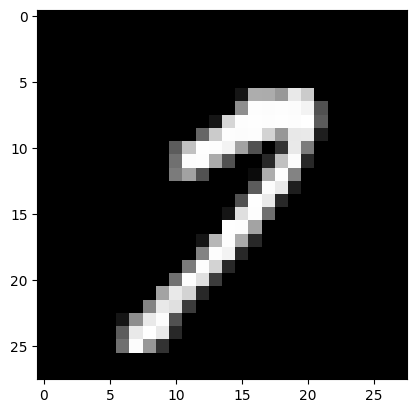

Prediction:  [1]
Label:  1


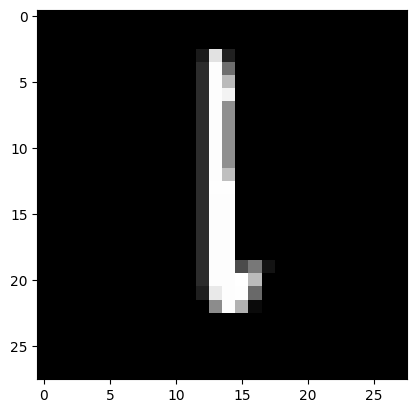

In [ ]:
test_prediction(62, w, b)
test_prediction(741, w, b)
test_prediction(201, w, b)
test_prediction(822, w, b)